![qiskit_header.png](../../images/qiskit_header.png)

# Qiskit Aer: Pulse simulation of a backend model

This notebook shows how to use the Aer pulse simulator using a model generated from a backend. In particular, we run a Rabi experiment on the Armonk one qubit backend, then simulate the same experiment on the pulse simulator, calibrating the model parameters to reproduce the results from the real backend.

## Table of contents

1) [Imports](#imports)


2) [Rabi oscillations on `ibmq_armonk`](#rabi)


3) [Reproducing Rabi oscillations on the simulator](#simulator)

## 1. Imports <a name='imports'></a>

Import general libraries:

In [1]:
import numpy as np

Import `IBMQ`, Rabi experiment generator and fitter from Ignis, and other functions for job submission:

In [2]:
#from qiskit import IBMQ

from qiskit.test.mock.backends.armonk.fake_armonk import FakeArmonk

from qiskit.ignis.characterization.calibrations import rabi_schedules, RabiFitter

from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

Import `PulseSimulator` and `PulseSystemModel` for pulse simulation:

In [3]:
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel

# 2. Rabi oscillations on `ibmq_armonk` backend <a name='rabi'></a>

First, we run a Rabi experiment on the `ibmq_armonk` backend using Ignis.

Get the `ibmq_armonk` backend:

In [4]:
#provider = IBMQ.load_account()
armonk_backend = FakeArmonk()#provider.get_backend('ibmq_armonk')

Construct Rabi experiment schedules.

In [5]:
# qubit list
qubits = [0]

# drive amplitudes to use
num_exps = 64
drive_amps = np.linspace(0, 1.0, num_exps)

# drive shape parameters
drive_duration = 2048
drive_sigma = 256

# list of drive channels
drive_channels = [DriveChannel(0)]

# construct the schedules
rabi_schedules, xdata = rabi_schedules(amp_list=drive_amps, 
                                       qubits=qubits, 
                                       pulse_width=drive_duration, 
                                       pulse_sigma=drive_sigma,
                                       drives=drive_channels, 
                                       inst_map=armonk_backend.defaults().instruction_schedule_map, 
                                       meas_map=armonk_backend.configuration().meas_map)

Assemble the `qobj` for job submission.

In [6]:
rabi_qobj = assemble(rabi_schedules, 
                     backend=armonk_backend, 
                     meas_level=MeasLevel.KERNELED, 
                     meas_return=MeasReturnType.AVERAGE, 
                     memory_slots=1,
                     shots=512)

Run the job on the backend.

In [7]:
job = armonk_backend.run(rabi_qobj)

In [8]:
job.status()

<JobStatus.ERROR: 'job incurred error'>

In [9]:
rabi_result = job.result(timeout=3600)

IndexError: list index out of range

Fit and plot the results, getting the $\pi$-pulse amplitude.

In [8]:
rabi_backend_fit = RabiFitter(rabi_result, xdata, qubits, fit_p0 = [2.0e15, 2, 0, 0])

# get the pi amplitude
pi_amp = rabi_backend_fit.pi_amplitude(0)

# plot
rabi_backend_fit.plot(0)
print('Pi Amp: %f'%pi_amp)

NameError: name 'rabi_result' is not defined

# 3. Reproducing the Rabi oscillations with the simulator <a name='simulator'></a>

Next, we run the same experiments on the pulse simulator. This section demonstrates the use of the `PulseSystemModel.from_backend` function for generating `PulseSystemModel` objects from a backend. 

**Note:** Currently not all system Hamiltonian information is available to the public, missing values have been replaced with $0$. As a result, in this notebook, we need to insert parameters into the backend object by hand. Specifically, we:
- Set the frequency of the qubit in the backend provided Hamiltonian to correspond with the backend provided estimate.
- Set the value of the drive strength to be consistent with the $\pi$-pulse amplitude found in the previous section. I.e. The drive strength $r$ is set so that: $r \times A = \pi/2$, where $A$ is the area under the $\pi$-pulse found above.

In [17]:
# A value to use if previous cells of notebook were not run
pi_amp = 0.347467

# Infer the value of the drive strength from the pi pulse amplitude:
dt = getattr(armonk_backend.configuration(), 'dt')
from qiskit.pulse import pulse_lib
sample_array = pulse_lib.gaussian(duration=drive_duration, amp=1, sigma=drive_sigma).samples
A = pi_amp*sum(sample_array*dt) # area under curve
#omegad0 = np.real(np.pi/(A * 2)) # inferred drive strength
omegad0 = np.real(np.pi/A)
# set drive strength omegad0 in backend object
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = omegad0
# set the qubit frequency from the estimate in the defaults
freq_est = 5*10**9
armonk_backend.defaults().qubit_freq_est = [freq_est]
getattr(armonk_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

In [18]:
armonk_backend.configuration().hamiltonian

{'description': 'Qubits are modelled as a two level system. Qubits are coupled through resonator buses. The provided Hamiltonian has been projected into the zero excitation subspace of the resonator buses leading to an effective qubit-qubit flip-flop interaction. The qubit resonance frequencies in the Hamiltonian are the cavity dressed frequencies and not exactly what is returned by the backend defaults, which also includes the dressing due to the qubit-qubit interactions.\nWarning: Currently not all system Hamiltonian information is available to the public, missing values have been replaced with 0.\n',
 'h_latex': '\\begin{align} \\mathcal{H}/\\hbar = & \\sum_{i=0}^{0}\\left(\\frac{\\omega_{q,i}}{2} (\\mathbb{1}_i-\\sigma_i^{z})+ \\Omega_{d,i}D_i(t)\\sigma_i^{X}\\right) \\\\ \\end{align}',
 'h_str': ['_SUM[i,0,0,wq{i}/2*(I{i}-Z{i})]',
  '_SUM[i,0,0,omegad{i}*X{i}||D{i}]'],
 'osc': {},
 'qub': {'0': 2},
 'vars': {'omegad0': 63455017.85140403, 'wq0': 31415926535.89793}}

Construct a `PulseSystemModel` object from the backend, and instantiate the simulator.

In [19]:
armonk_model = PulseSystemModel.from_backend(armonk_backend)

backend_sim = PulseSimulator()

In [20]:
armonk_model.hamiltonian._system

[(<qiskit.providers.aer.pulse.qutip_extra_lite.qobj.Qobj at 0x7fe25a44af40>,
  'wq0/2'),
 (<qiskit.providers.aer.pulse.qutip_extra_lite.qobj.Qobj at 0x7fe25a44a580>,
  'omegad0*D0')]

Assemble schedules as before, but now use `PulseSimulator` as the backend.

In [21]:
rabi_qobj_sim = assemble(rabi_schedules, 
                         backend=backend_sim,
                         meas_level=1, 
                         meas_return='avg',
                         shots=512)

Run the simulation and get the results.

In [22]:
len(rabi_qobj_sim.experiments)

64

In [23]:
sim_result = backend_sim.run(rabi_qobj_sim, armonk_model).result()

Generate the same plot.

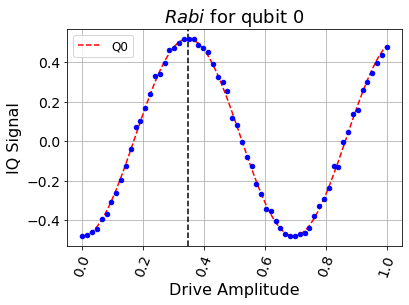

In [24]:
rabi_sim_fit = RabiFitter(sim_result, xdata, qubits, fit_p0 = [1.5, 2, 0, 0])
rabi_sim_fit.plot(0)

Observe: the simulated results reproduce the oscillations of the device (the amplitude of the oscillation is arbitrary).

In [16]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright